In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')

In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Reference Model

In [3]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time = np.unique(results['time'].values)
T = len(time)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, T, M, C))
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
print (np.shape(ref_traj))

(10, 201, 62, 7)


Plotting 62 patches in a 7 x 9 grid


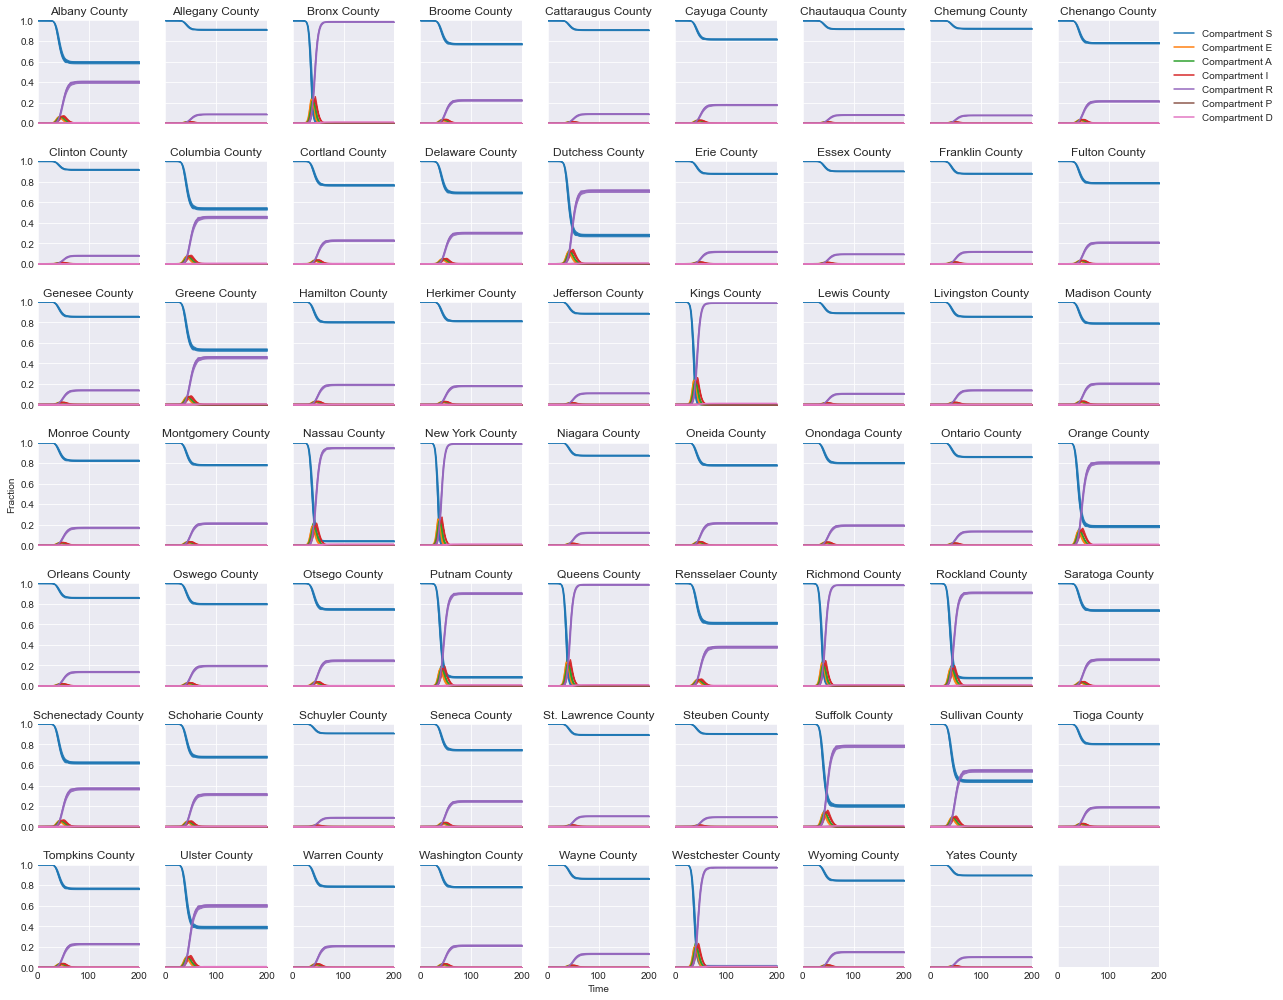

In [4]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.9, names=['S','E','A','I','R','P','D'])
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [5]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

In [4]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)

## Restraining a sample SEAIRPD to reference

In [5]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 4)
#tmat.add_transition('I', 'P', 5, 2)
#tmat.add_transition('P', 'D', 5, 2)
#tmat.add_transition('D', 'R', 5, 2)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.0001
hyper_pram.beta_high = 0.5
hyper_pram.beta_var = 0.1
hyper_pram.start_high = 0.01
# hyper_pram.start_var = 0.1
# hyper_pram.R_var = 0.001
hyper_pram.beta_start = 0.1
hyper_pram.start_mean = 0.001
# hyper_pram.start_scale = 0.1

start_logits = np.zeros((M,))
start_logits[:]=np.log(0.01)
param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
import tqdm
N = 256
batches = 4
outs = []
infect = maxentep.contact_infection_func(infections_compartments,area = area)
model = maxentep.MetaModel(infect, T,populations = np.round(population))
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.36s/it]


(1024, 201, 62, 5)


## Make restraints from reference trajectory

10 0.0 0.0
59 0.03264781553658353 0.03264781553658353
24 5.157765341904389e-05 5.157765341904389e-05
31 0.001500923471580403 0.001500923471580403
38 0.023048690990878817 0.023048690990878817
52 0.06820595816484552 0.06820595816484552
17 1.7084806191201018e-06 1.7084806191201018e-06
66 0.010138492724826488 0.010138492724826488


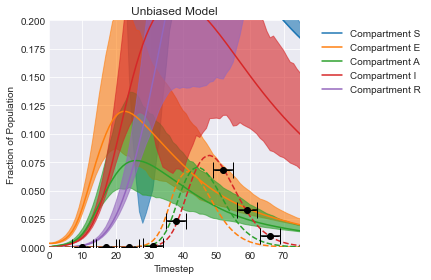

In [7]:
# Plotting restraints on reference traj
full_compartments = ['S'] + compartments
p = 1 # picking one trajectory from the parameter set
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,0,:4], linestyle='--')
plt.title('Unbiased Model')

npoints =8
prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,3], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
#restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
restraints = restraints_R
plot_fxns = plot_fxn_R
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
plt.ylim(0,0.2)
plt.xlim(0,75)
plt.show()


In [8]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [9]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [66]:
me_history = me_model.fit(trajs, batch_size=64,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7500e-04 - weight-entropy: 2.7227
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6686e-04 - weight-entropy: 2.7914
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9244e-04 - weight-entropy: 2.7782
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7674e-04 - weight-entropy: 2.7324
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8970e-04 - weight-entropy: 2.7425
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.1817e-04 - weight-entropy: 2.7731
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0508e-04 - weight-entropy: 2.8133
Epoch 8/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4510e-04 - weight-entropy: 2.7608
Epoch 9/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9907e-04 - weight-entropy: 2.7976
Epoch 10/1

16/16 [==============================] - 0s 2ms/step - loss: 2.3856e-04 - weight-entropy: 2.8021
Epoch 75/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6095e-04 - weight-entropy: 2.7700
Epoch 76/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3680e-04 - weight-entropy: 2.7580
Epoch 77/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3311e-04 - weight-entropy: 2.7825
Epoch 78/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7956e-04 - weight-entropy: 2.7803
Epoch 79/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4649e-04 - weight-entropy: 2.7950
Epoch 80/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4349e-04 - weight-entropy: 2.7926
Epoch 81/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5611e-04 - weight-entropy: 2.7615
Epoch 82/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0404e-04 - weight-entropy: 2.7666
Epoch 83/1000
1

16/16 [==============================] - 0s 1ms/step - loss: 2.8155e-04 - weight-entropy: 2.7175
Epoch 148/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5857e-04 - weight-entropy: 2.7641
Epoch 149/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.1293e-04 - weight-entropy: 2.7884
Epoch 150/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4214e-04 - weight-entropy: 2.7866
Epoch 151/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6490e-04 - weight-entropy: 2.7567
Epoch 152/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5722e-04 - weight-entropy: 2.7715
Epoch 153/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7313e-04 - weight-entropy: 2.7700
Epoch 154/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6406e-04 - weight-entropy: 2.7581
Epoch 155/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7593e-04 - weight-entropy: 2.7698
Epoch 1

16/16 [==============================] - 0s 1ms/step - loss: 2.5746e-04 - weight-entropy: 2.7080
Epoch 220/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.2675e-04 - weight-entropy: 2.7995
Epoch 221/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1538e-04 - weight-entropy: 2.7971
Epoch 222/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4556e-04 - weight-entropy: 2.7375
Epoch 223/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7075e-04 - weight-entropy: 2.7726
Epoch 224/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4261e-04 - weight-entropy: 2.7516
Epoch 225/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9198e-04 - weight-entropy: 2.7703
Epoch 226/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.2696e-04 - weight-entropy: 2.7774
Epoch 227/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5712e-04 - weight-entropy: 2.8026
Epoch 2

16/16 [==============================] - 0s 1ms/step - loss: 2.4785e-04 - weight-entropy: 2.7710
Epoch 293/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1976e-04 - weight-entropy: 2.7568
Epoch 294/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6931e-04 - weight-entropy: 2.7039
Epoch 295/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5803e-04 - weight-entropy: 2.7263
Epoch 296/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5183e-04 - weight-entropy: 2.7745
Epoch 297/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2207e-04 - weight-entropy: 2.7757
Epoch 298/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6875e-04 - weight-entropy: 2.7244
Epoch 299/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8032e-04 - weight-entropy: 2.7207
Epoch 300/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5277e-04 - weight-entropy: 2.7888
Epoch 3

16/16 [==============================] - 0s 2ms/step - loss: 2.9218e-04 - weight-entropy: 2.6851
Epoch 366/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7964e-04 - weight-entropy: 2.7384
Epoch 367/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9734e-04 - weight-entropy: 2.7624
Epoch 368/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6224e-04 - weight-entropy: 2.7715
Epoch 369/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0301e-04 - weight-entropy: 2.7802
Epoch 370/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3828e-04 - weight-entropy: 2.7418
Epoch 371/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8367e-04 - weight-entropy: 2.7754
Epoch 372/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8137e-04 - weight-entropy: 2.7673
Epoch 373/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6773e-04 - weight-entropy: 2.7177
Epoch 3

16/16 [==============================] - 0s 2ms/step - loss: 2.5429e-04 - weight-entropy: 2.7673
Epoch 439/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8055e-04 - weight-entropy: 2.7922
Epoch 440/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4282e-04 - weight-entropy: 2.7662
Epoch 441/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.1364e-04 - weight-entropy: 2.7989
Epoch 442/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6234e-04 - weight-entropy: 2.8102
Epoch 443/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7809e-04 - weight-entropy: 2.7657
Epoch 444/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5315e-04 - weight-entropy: 2.7466
Epoch 445/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6230e-04 - weight-entropy: 2.7797
Epoch 446/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9871e-04 - weight-entropy: 2.7686
Epoch 4

16/16 [==============================] - 0s 2ms/step - loss: 3.1036e-04 - weight-entropy: 2.7911
Epoch 512/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9447e-04 - weight-entropy: 2.7212
Epoch 513/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7846e-04 - weight-entropy: 2.7501
Epoch 514/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4383e-04 - weight-entropy: 2.7639
Epoch 515/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6814e-04 - weight-entropy: 2.7359
Epoch 516/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7221e-04 - weight-entropy: 2.7488
Epoch 517/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.7408e-04 - weight-entropy: 2.7847
Epoch 518/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6018e-04 - weight-entropy: 2.7103
Epoch 519/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.2757e-04 - weight-entropy: 2.7901
Epoch 5

16/16 [==============================] - 0s 1ms/step - loss: 2.9179e-04 - weight-entropy: 2.7271
Epoch 585/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.3683e-04 - weight-entropy: 2.7340
Epoch 586/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0862e-04 - weight-entropy: 2.7998
Epoch 587/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7248e-04 - weight-entropy: 2.7130
Epoch 588/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6835e-04 - weight-entropy: 2.7393
Epoch 589/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1407e-04 - weight-entropy: 2.7455
Epoch 590/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6033e-04 - weight-entropy: 2.7547
Epoch 591/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5914e-04 - weight-entropy: 2.7954
Epoch 592/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7878e-04 - weight-entropy: 2.7250
Epoch 5

16/16 [==============================] - 0s 1ms/step - loss: 3.0650e-04 - weight-entropy: 2.7312
Epoch 657/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4334e-04 - weight-entropy: 2.7564
Epoch 658/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4823e-04 - weight-entropy: 2.7760
Epoch 659/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0338e-04 - weight-entropy: 2.7458
Epoch 660/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6262e-04 - weight-entropy: 2.7201
Epoch 661/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4336e-04 - weight-entropy: 2.7706
Epoch 662/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8098e-04 - weight-entropy: 2.7896
Epoch 663/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4910e-04 - weight-entropy: 2.7601
Epoch 664/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6404e-04 - weight-entropy: 2.7621
Epoch 6

16/16 [==============================] - 0s 2ms/step - loss: 2.9345e-04 - weight-entropy: 2.6819
Epoch 730/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4573e-04 - weight-entropy: 2.7310
Epoch 731/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7799e-04 - weight-entropy: 2.7728
Epoch 732/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2084e-04 - weight-entropy: 2.7363
Epoch 733/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7769e-04 - weight-entropy: 2.7119
Epoch 734/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7007e-04 - weight-entropy: 2.7401
Epoch 735/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4205e-04 - weight-entropy: 2.7746
Epoch 736/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2643e-04 - weight-entropy: 2.7634
Epoch 737/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1672e-04 - weight-entropy: 2.6940
Epoch 7

16/16 [==============================] - 0s 2ms/step - loss: 4.1014e-04 - weight-entropy: 2.7094
Epoch 803/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5328e-04 - weight-entropy: 2.6812
Epoch 804/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4839e-04 - weight-entropy: 2.7377
Epoch 805/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.1986e-04 - weight-entropy: 2.7890
Epoch 806/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7818e-04 - weight-entropy: 2.7704
Epoch 807/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5419e-04 - weight-entropy: 2.7293
Epoch 808/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0260e-04 - weight-entropy: 2.7695
Epoch 809/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4970e-04 - weight-entropy: 2.7417
Epoch 810/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4608e-04 - weight-entropy: 2.7527
Epoch 8

16/16 [==============================] - 0s 2ms/step - loss: 2.6380e-04 - weight-entropy: 2.7168
Epoch 876/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4621e-04 - weight-entropy: 2.7642
Epoch 877/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.6401e-04 - weight-entropy: 2.7217
Epoch 878/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9443e-04 - weight-entropy: 2.7387
Epoch 879/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5992e-04 - weight-entropy: 2.7287
Epoch 880/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3572e-04 - weight-entropy: 2.7462
Epoch 881/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7303e-04 - weight-entropy: 2.7968
Epoch 882/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5809e-04 - weight-entropy: 2.7485
Epoch 883/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0335e-04 - weight-entropy: 2.7800
Epoch 8

16/16 [==============================] - 0s 2ms/step - loss: 2.7792e-04 - weight-entropy: 2.7634
Epoch 948/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3909e-04 - weight-entropy: 2.7316
Epoch 949/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.2803e-04 - weight-entropy: 2.7732
Epoch 950/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2952e-04 - weight-entropy: 2.7773
Epoch 951/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6436e-04 - weight-entropy: 2.7036
Epoch 952/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8377e-04 - weight-entropy: 2.7270
Epoch 953/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.2150e-04 - weight-entropy: 2.7954
Epoch 954/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5301e-04 - weight-entropy: 2.7791
Epoch 955/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7389e-04 - weight-entropy: 2.7586
Epoch 9

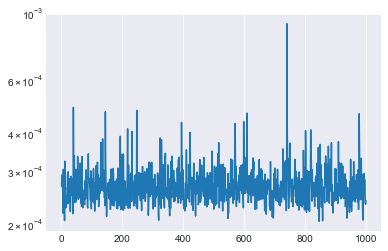

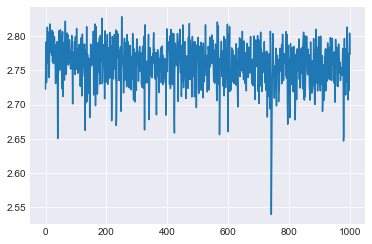

In [67]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.show()

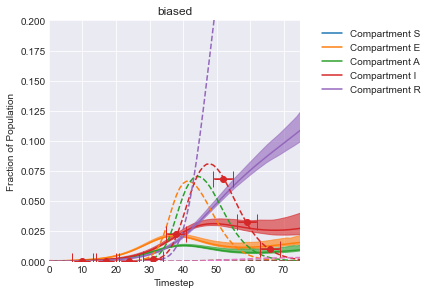

In [40]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, me_model.lambdas[i], color='C3')
plt.tight_layout()
plt.ylim(0,0.2)
plt.xlim(0,75)
plt.title('biased')
plt.show()

## Algorithm 2

In [100]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )
fit_param_model.compile(tf.optimizers.SGD(1))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [101]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=64, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0177 - weight-entropy: 4.1589
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0177 - weight-entropy: 4.1588
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0178 - weight-entropy: 4.1587
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0174 - weight-entropy: 4.1585
Epoch 5/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0170 - weight-entropy: 4.1583
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0170 - weight-entropy: 4.1580
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0167 - weight-entropy: 4.1576
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0167 - weight-entropy: 4.1572
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0165 - weight-entropy: 4.1567
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 2ms/step - loss: 0.0088 - weight-entropy: 4.0626
Epoch 73/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0090 - weight-entropy: 4.0616
Epoch 74/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0085 - weight-entropy: 4.0574
Epoch 75/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0090 - weight-entropy: 4.0593
Epoch 76/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0082 - weight-entropy: 4.0530
Epoch 77/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0081 - weight-entropy: 4.0506
Epoch 78/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0085 - weight-entropy: 4.0511
Epoch 79/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0081 - weight-entropy: 4.0472
Epoch 80/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0084 - weight-entropy: 4.0474
Epoch 81/1000
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 3.9113
Epoch 150/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 3.9085
Epoch 151/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 3.9073
Epoch 152/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 3.9046
Epoch 153/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0046 - weight-entropy: 3.9023
Epoch 154/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 3.9006
Epoch 155/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 3.8991
Epoch 156/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 3.8998
Epoch 157/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0045 - weight-entropy: 3.8952
Epoch 158/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.7889
Epoch 226/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.7874
Epoch 227/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.7887
Epoch 228/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 3.7911
Epoch 229/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 3.7840
Epoch 230/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.7826
Epoch 231/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 3.7892
Epoch 232/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.7832
Epoch 233/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.7815
Epoch 234/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.6981
Epoch 303/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.7003
Epoch 304/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.6959
Epoch 305/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.7055
Epoch 306/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.6926
Epoch 307/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.6943
Epoch 308/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.6949
Epoch 309/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.6906
Epoch 310/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.6905
Epoch 311/1000
4/4 [==============================] - 0s 2ms/

Epoch 379/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.6303
Epoch 380/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.6232
Epoch 381/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.6249
Epoch 382/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.6235
Epoch 383/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.6250
Epoch 384/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.6279
Epoch 385/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.6204
Epoch 386/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.6245
Epoch 387/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.6196
Epoch 388/1000
4/4 [==========================

4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5717
Epoch 456/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.5789
Epoch 457/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5666
Epoch 458/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5704
Epoch 459/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5689
Epoch 460/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.5679
Epoch 461/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.5749
Epoch 462/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 3.5734
Epoch 463/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5685
Epoch 464/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5283
Epoch 533/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5359
Epoch 534/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5228
Epoch 535/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5241
Epoch 536/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5225
Epoch 537/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5267
Epoch 538/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5227
Epoch 539/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5278
Epoch 540/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5202
Epoch 541/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4903
Epoch 609/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4913
Epoch 610/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5019
Epoch 611/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.4843
Epoch 612/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4937
Epoch 613/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4849
Epoch 614/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4854
Epoch 615/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.4836
Epoch 616/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4882
Epoch 617/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4657
Epoch 685/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.4604
Epoch 686/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.8398e-04 - weight-entropy: 3.4567
Epoch 687/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.0329e-04 - weight-entropy: 3.4514
Epoch 688/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.8679e-04 - weight-entropy: 3.4555
Epoch 689/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.4531
Epoch 690/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.1023e-04 - weight-entropy: 3.4504
Epoch 691/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.5706e-04 - weight-entropy: 3.4527
Epoch 692/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4596
Epoch 693/1000
4/4 [=====================

4/4 [==============================] - 0s 1ms/step - loss: 8.4406e-04 - weight-entropy: 3.4227
Epoch 760/1000
4/4 [==============================] - 0s 1ms/step - loss: 9.2227e-04 - weight-entropy: 3.4282
Epoch 761/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.9534e-04 - weight-entropy: 3.4247
Epoch 762/1000
4/4 [==============================] - 0s 1ms/step - loss: 9.3607e-04 - weight-entropy: 3.4286
Epoch 763/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4388
Epoch 764/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.4898e-04 - weight-entropy: 3.4335
Epoch 765/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4349
Epoch 766/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.5042e-04 - weight-entropy: 3.4237
Epoch 767/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.4837e-04 - weight-entropy: 3.4248
Epoch 768/1000
4/4 [=============

4/4 [==============================] - 0s 1ms/step - loss: 7.5526e-04 - weight-entropy: 3.4012
Epoch 834/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4209
Epoch 835/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4268
Epoch 836/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.3620e-04 - weight-entropy: 3.4057
Epoch 837/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4183
Epoch 838/1000
4/4 [==============================] - 0s 1ms/step - loss: 8.2110e-04 - weight-entropy: 3.4040
Epoch 839/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.4288e-04 - weight-entropy: 3.4054
Epoch 840/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.2648e-04 - weight-entropy: 3.4001
Epoch 841/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.0249e-04 - weight-entropy: 3.4009
Epoch 842/1000
4/4 [=================

4/4 [==============================] - 0s 2ms/step - loss: 8.2870e-04 - weight-entropy: 3.3887
Epoch 908/1000
4/4 [==============================] - 0s 1ms/step - loss: 9.1146e-04 - weight-entropy: 3.3914
Epoch 909/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.0827e-04 - weight-entropy: 3.3768
Epoch 910/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.1483e-04 - weight-entropy: 3.3788
Epoch 911/1000
4/4 [==============================] - 0s 2ms/step - loss: 8.2755e-04 - weight-entropy: 3.3876
Epoch 912/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.9123e-04 - weight-entropy: 3.3812
Epoch 913/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.5464e-04 - weight-entropy: 3.3818
Epoch 914/1000
4/4 [==============================] - 0s 1ms/step - loss: 7.1816e-04 - weight-entropy: 3.3813
Epoch 915/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.3131e-04 - weight-entropy: 3.3813
Epoch 916/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.5533e-04 - weight-entropy: 3.3684
Epoch 982/1000
4/4 [==============================] - 0s 1ms/step - loss: 6.7459e-04 - weight-entropy: 3.3626
Epoch 983/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.3832
Epoch 984/1000
4/4 [==============================] - 0s 1ms/step - loss: 7.1500e-04 - weight-entropy: 3.3663
Epoch 985/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.6591e-04 - weight-entropy: 3.3619
Epoch 986/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.0753e-04 - weight-entropy: 3.3649
Epoch 987/1000
4/4 [==============================] - 0s 1ms/step - loss: 7.4680e-04 - weight-entropy: 3.3668
Epoch 988/1000
4/4 [==============================] - 0s 2ms/step - loss: 6.9832e-04 - weight-entropy: 3.3637
Epoch 989/1000
4/4 [==============================] - 0s 2ms/step - loss: 6.7982e-04 - weight-entropy: 3.3632
Epoch 990/1000
4/4 [=========

8/8 [==============================] - 0s 12ms/step - loss: 1.6158 - R-dist-dist_loss: 2.0046 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1537 - beta-dist_loss: -0.2203
Epoch 33/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6150 - R-dist-dist_loss: 2.0039 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1537 - beta-dist_loss: -0.2204
Epoch 34/50
8/8 [==============================] - 0s 11ms/step - loss: 1.6142 - R-dist-dist_loss: 2.0032 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1537 - beta-dist_loss: -0.2204
Epoch 35/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6134 - R-dist-dist_loss: 2.0025 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1537 - beta-dist_loss: -0.2205
Epoch 36/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6127 - R-dist-dist_loss: 2.0018 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1537 - beta-dist_loss: -0.2206
Epoch 37/50
8/8 [==============================] - 0s 11ms/ste

4/4 [==============================] - 0s 2ms/step - loss: 5.6883e-04 - weight-entropy: 3.6309
Epoch 44/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3294e-04 - weight-entropy: 3.6298
Epoch 45/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1085e-04 - weight-entropy: 3.6295
Epoch 46/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3756e-04 - weight-entropy: 3.6313
Epoch 47/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.7301e-04 - weight-entropy: 3.6304
Epoch 48/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9804e-04 - weight-entropy: 3.6246
Epoch 49/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.4539e-04 - weight-entropy: 3.6271
Epoch 50/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1735e-04 - weight-entropy: 3.6299
Epoch 51/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.2872e-04 - weight-entropy: 3.6296
Epoch 52/1000
4/4 [==============

4/4 [==============================] - 0s 1ms/step - loss: 5.6072e-04 - weight-entropy: 3.6267
Epoch 118/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9497e-04 - weight-entropy: 3.6226
Epoch 119/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1264e-04 - weight-entropy: 3.6243
Epoch 120/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.0986e-04 - weight-entropy: 3.6239
Epoch 121/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.1685e-04 - weight-entropy: 3.6256
Epoch 122/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9075e-04 - weight-entropy: 3.6191
Epoch 123/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.0841e-04 - weight-entropy: 3.6228
Epoch 124/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1340e-04 - weight-entropy: 3.6246
Epoch 125/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.9660e-04 - weight-entropy: 3.6203
Epoch 126/1000
4/4 [=====

4/4 [==============================] - 0s 1ms/step - loss: 4.9001e-04 - weight-entropy: 3.6189
Epoch 192/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.2509e-04 - weight-entropy: 3.6207
Epoch 193/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.1611e-04 - weight-entropy: 3.6209
Epoch 194/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.5203e-04 - weight-entropy: 3.6230
Epoch 195/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8679e-04 - weight-entropy: 3.6192
Epoch 196/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.0968e-04 - weight-entropy: 3.6198
Epoch 197/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9638e-04 - weight-entropy: 3.6195
Epoch 198/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.6521e-04 - weight-entropy: 3.6209
Epoch 199/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.3806e-04 - weight-entropy: 3.6215
Epoch 200/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 4.7993e-04 - weight-entropy: 3.6112
Epoch 266/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.7132e-04 - weight-entropy: 3.6198
Epoch 267/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8297e-04 - weight-entropy: 3.6146
Epoch 268/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.8691e-04 - weight-entropy: 3.6120
Epoch 269/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7778e-04 - weight-entropy: 3.6130
Epoch 270/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3201e-04 - weight-entropy: 3.6136
Epoch 271/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.8116e-04 - weight-entropy: 3.6132
Epoch 272/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.3935e-04 - weight-entropy: 3.6165
Epoch 273/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8995e-04 - weight-entropy: 3.6152
Epoch 274/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 5.3510e-04 - weight-entropy: 3.6108
Epoch 340/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3141e-04 - weight-entropy: 3.6116
Epoch 341/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8312e-04 - weight-entropy: 3.6077
Epoch 342/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.1973e-04 - weight-entropy: 3.6096
Epoch 343/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.1522e-04 - weight-entropy: 3.6127
Epoch 344/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.0200e-04 - weight-entropy: 3.6110
Epoch 345/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8356e-04 - weight-entropy: 3.6104
Epoch 346/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.2177e-04 - weight-entropy: 3.6076
Epoch 347/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1512e-04 - weight-entropy: 3.6114
Epoch 348/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 4.7328e-04 - weight-entropy: 3.6059
Epoch 414/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7012e-04 - weight-entropy: 3.6046
Epoch 415/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9155e-04 - weight-entropy: 3.6068
Epoch 416/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8580e-04 - weight-entropy: 3.6040
Epoch 417/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7155e-04 - weight-entropy: 3.6053
Epoch 418/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8919e-04 - weight-entropy: 3.6059
Epoch 419/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8349e-04 - weight-entropy: 3.6039
Epoch 420/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9196e-04 - weight-entropy: 3.6051
Epoch 421/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8286e-04 - weight-entropy: 3.6053
Epoch 422/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 5.2896e-04 - weight-entropy: 3.6029
Epoch 488/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9331e-04 - weight-entropy: 3.6032
Epoch 489/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7392e-04 - weight-entropy: 3.5974
Epoch 490/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3028e-04 - weight-entropy: 3.6066
Epoch 491/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.8669e-04 - weight-entropy: 3.6052
Epoch 492/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.0007e-04 - weight-entropy: 3.6025
Epoch 493/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.0244e-04 - weight-entropy: 3.6008
Epoch 494/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7759e-04 - weight-entropy: 3.6018
Epoch 495/1000
4/4 [==============================] - 0s 1ms/step - loss: 5.3405e-04 - weight-entropy: 3.6038
Epoch 496/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 4.5966e-04 - weight-entropy: 3.5977
Epoch 562/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9868e-04 - weight-entropy: 3.5966
Epoch 563/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7661e-04 - weight-entropy: 3.5983
Epoch 564/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7149e-04 - weight-entropy: 3.5980
Epoch 565/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6223e-04 - weight-entropy: 3.5946
Epoch 566/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6741e-04 - weight-entropy: 3.5967
Epoch 567/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5367e-04 - weight-entropy: 3.5933
Epoch 568/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.5848e-04 - weight-entropy: 3.6023
Epoch 569/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5769e-04 - weight-entropy: 3.5961
Epoch 570/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 4.9282e-04 - weight-entropy: 3.5959
Epoch 636/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5178e-04 - weight-entropy: 3.5942
Epoch 637/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6373e-04 - weight-entropy: 3.5924
Epoch 638/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7348e-04 - weight-entropy: 3.5936
Epoch 639/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.8010e-04 - weight-entropy: 3.5941
Epoch 640/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7359e-04 - weight-entropy: 3.5923
Epoch 641/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7683e-04 - weight-entropy: 3.5939
Epoch 642/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6996e-04 - weight-entropy: 3.5951
Epoch 643/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.7723e-04 - weight-entropy: 3.5925
Epoch 644/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 4.7751e-04 - weight-entropy: 3.5910
Epoch 710/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.6635e-04 - weight-entropy: 3.5912
Epoch 711/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4449e-04 - weight-entropy: 3.5844
Epoch 712/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6456e-04 - weight-entropy: 3.5906
Epoch 713/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1482e-04 - weight-entropy: 3.5951
Epoch 714/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.9905e-04 - weight-entropy: 3.5924
Epoch 715/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5430e-04 - weight-entropy: 3.5889
Epoch 716/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3742e-04 - weight-entropy: 3.5952
Epoch 717/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.5543e-04 - weight-entropy: 3.5896
Epoch 718/1000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 4.5241e-04 - weight-entropy: 3.5869
Epoch 784/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5807e-04 - weight-entropy: 3.5852
Epoch 785/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4466e-04 - weight-entropy: 3.5859
Epoch 786/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5364e-04 - weight-entropy: 3.5860
Epoch 787/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.3839e-04 - weight-entropy: 3.5910
Epoch 788/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4461e-04 - weight-entropy: 3.5837
Epoch 789/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6916e-04 - weight-entropy: 3.5854
Epoch 790/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6874e-04 - weight-entropy: 3.5885
Epoch 791/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4798e-04 - weight-entropy: 3.5837
Epoch 792/1000
4/4 [=====

4/4 [==============================] - 0s 1ms/step - loss: 4.4500e-04 - weight-entropy: 3.5838
Epoch 858/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.6883e-04 - weight-entropy: 3.5841
Epoch 859/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4420e-04 - weight-entropy: 3.5839
Epoch 860/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5731e-04 - weight-entropy: 3.5821
Epoch 861/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.8290e-04 - weight-entropy: 3.5849
Epoch 862/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4168e-04 - weight-entropy: 3.5804
Epoch 863/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4542e-04 - weight-entropy: 3.5826
Epoch 864/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.6642e-04 - weight-entropy: 3.5849
Epoch 865/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5519e-04 - weight-entropy: 3.5812
Epoch 866/1000
4/4 [=====

4/4 [==============================] - 0s 1ms/step - loss: 4.6720e-04 - weight-entropy: 3.5812
Epoch 932/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.3679e-04 - weight-entropy: 3.5796
Epoch 933/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.5117e-04 - weight-entropy: 3.5790
Epoch 934/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.2409e-04 - weight-entropy: 3.5843
Epoch 935/1000
4/4 [==============================] - 0s 2ms/step - loss: 5.1954e-04 - weight-entropy: 3.5838
Epoch 936/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.6252e-04 - weight-entropy: 3.5811
Epoch 937/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.9542e-04 - weight-entropy: 3.5807
Epoch 938/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.4801e-04 - weight-entropy: 3.5804
Epoch 939/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.4602e-04 - weight-entropy: 3.5785
Epoch 940/1000
4/4 [=====

8/8 [==============================] - 0s 12ms/step - loss: 1.8043 - R-dist-dist_loss: 2.2128 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2418
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 1.8004 - R-dist-dist_loss: 2.2089 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2419
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7968 - R-dist-dist_loss: 2.2054 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2420
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 1.7936 - R-dist-dist_loss: 2.2023 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2420
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 1.7908 - R-dist-dist_loss: 2.1995 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2421
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - l

8/8 [==============================] - 0s 12ms/step - loss: 1.7564 - R-dist-dist_loss: 2.1663 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2432
Epoch 47/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7561 - R-dist-dist_loss: 2.1661 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2433
Epoch 48/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7558 - R-dist-dist_loss: 2.1658 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2433
Epoch 49/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7555 - R-dist-dist_loss: 2.1655 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2433
Epoch 50/50
8/8 [==============================] - 0s 11ms/step - loss: 1.7553 - R-dist-dist_loss: 2.1654 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1541 - beta-dist_loss: -0.2433
Epoch 1/1000
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.0119
Epoch 69/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.0096
Epoch 70/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0073
Epoch 71/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0046
Epoch 72/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0037
Epoch 73/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0015
Epoch 74/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 3.9997
Epoch 75/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.9975
Epoch 76/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.9977
Epoch 77/1000
16/16 [==============================

16/16 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.8998
Epoch 145/1000
16/16 [==============================] - 0s 2ms/step - loss: 9.4823e-04 - weight-entropy: 3.8971
Epoch 146/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.8987
Epoch 147/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.9138e-04 - weight-entropy: 3.8963
Epoch 148/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.9669e-04 - weight-entropy: 3.8954
Epoch 149/1000
16/16 [==============================] - 0s 2ms/step - loss: 9.8711e-04 - weight-entropy: 3.8941
Epoch 150/1000
16/16 [==============================] - 0s 2ms/step - loss: 9.7338e-04 - weight-entropy: 3.8931
Epoch 151/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.6110e-04 - weight-entropy: 3.8918
Epoch 152/1000
16/16 [==============================] - 0s 2ms/step - loss: 9.7705e-04 - weight-entropy: 3.8915
Epoch 153/1000


16/16 [==============================] - 0s 2ms/step - loss: 7.1438e-04 - weight-entropy: 3.8361
Epoch 218/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.3464e-04 - weight-entropy: 3.8358
Epoch 219/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.6124e-04 - weight-entropy: 3.8364
Epoch 220/1000
16/16 [==============================] - 0s 2ms/step - loss: 7.2193e-04 - weight-entropy: 3.8346
Epoch 221/1000
16/16 [==============================] - 0s 2ms/step - loss: 7.4938e-04 - weight-entropy: 3.8352
Epoch 222/1000
16/16 [==============================] - 0s 2ms/step - loss: 7.4124e-04 - weight-entropy: 3.8345
Epoch 223/1000
16/16 [==============================] - 0s 2ms/step - loss: 7.5056e-04 - weight-entropy: 3.8336
Epoch 224/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.8436e-04 - weight-entropy: 3.8338
Epoch 225/1000
16/16 [==============================] - 0s 2ms/step - loss: 7.3164e-04 - weight-entropy: 3.8320
Epoch 2

16/16 [==============================] - 0s 2ms/step - loss: 6.3660e-04 - weight-entropy: 3.7960
Epoch 290/1000
16/16 [==============================] - 0s 2ms/step - loss: 6.5009e-04 - weight-entropy: 3.7962
Epoch 291/1000
16/16 [==============================] - 0s 2ms/step - loss: 6.3160e-04 - weight-entropy: 3.7941
Epoch 292/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.4415e-04 - weight-entropy: 3.7952
Epoch 293/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.3150e-04 - weight-entropy: 3.7936
Epoch 294/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.1422e-04 - weight-entropy: 3.7928
Epoch 295/1000
16/16 [==============================] - 0s 2ms/step - loss: 6.2390e-04 - weight-entropy: 3.7931
Epoch 296/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.1218e-04 - weight-entropy: 3.7918
Epoch 297/1000
16/16 [==============================] - 0s 2ms/step - loss: 5.9277e-04 - weight-entropy: 3.7908
Epoch 2

16/16 [==============================] - 0s 2ms/step - loss: 5.3790e-04 - weight-entropy: 3.7636
Epoch 363/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.8447e-04 - weight-entropy: 3.7646
Epoch 364/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2603e-04 - weight-entropy: 3.7631
Epoch 365/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2936e-04 - weight-entropy: 3.7617
Epoch 366/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2048e-04 - weight-entropy: 3.7615
Epoch 367/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2593e-04 - weight-entropy: 3.7616
Epoch 368/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.5915e-04 - weight-entropy: 3.7628
Epoch 369/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.6209e-04 - weight-entropy: 3.7625
Epoch 370/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.6138e-04 - weight-entropy: 3.7620
Epoch 3

16/16 [==============================] - 0s 2ms/step - loss: 5.2463e-04 - weight-entropy: 3.7400
Epoch 436/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.9801e-04 - weight-entropy: 3.7394
Epoch 437/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.1910e-04 - weight-entropy: 3.7401
Epoch 438/1000
16/16 [==============================] - 0s 2ms/step - loss: 5.1262e-04 - weight-entropy: 3.7401
Epoch 439/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2525e-04 - weight-entropy: 3.7404
Epoch 440/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2121e-04 - weight-entropy: 3.7397
Epoch 441/1000
16/16 [==============================] - 0s 2ms/step - loss: 5.2317e-04 - weight-entropy: 3.7398
Epoch 442/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2118e-04 - weight-entropy: 3.7384
Epoch 443/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.2554e-04 - weight-entropy: 3.7392
Epoch 4

16/16 [==============================] - 0s 1ms/step - loss: 5.0103e-04 - weight-entropy: 3.7227
Epoch 509/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.8255e-04 - weight-entropy: 3.7214
Epoch 510/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.7182e-04 - weight-entropy: 3.7203
Epoch 511/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.0590e-04 - weight-entropy: 3.7203
Epoch 512/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.7985e-04 - weight-entropy: 3.7204
Epoch 513/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.9989e-04 - weight-entropy: 3.7202
Epoch 514/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.7820e-04 - weight-entropy: 3.7201
Epoch 515/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.6787e-04 - weight-entropy: 3.7196
Epoch 516/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.6052e-04 - weight-entropy: 3.7184
Epoch 5

16/16 [==============================] - 0s 1ms/step - loss: 4.6171e-04 - weight-entropy: 3.7060
Epoch 582/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.6018e-04 - weight-entropy: 3.7042
Epoch 583/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4667e-04 - weight-entropy: 3.7039
Epoch 584/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.5966e-04 - weight-entropy: 3.7040
Epoch 585/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.5911e-04 - weight-entropy: 3.7053
Epoch 586/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.5043e-04 - weight-entropy: 3.7038
Epoch 587/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.6148e-04 - weight-entropy: 3.7043
Epoch 588/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.9299e-04 - weight-entropy: 3.7052
Epoch 589/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4871e-04 - weight-entropy: 3.7030
Epoch 5

16/16 [==============================] - 0s 2ms/step - loss: 4.4049e-04 - weight-entropy: 3.6922
Epoch 655/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.6587e-04 - weight-entropy: 3.6929
Epoch 656/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3771e-04 - weight-entropy: 3.6920
Epoch 657/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4064e-04 - weight-entropy: 3.6903
Epoch 658/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4478e-04 - weight-entropy: 3.6923
Epoch 659/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.2636e-04 - weight-entropy: 3.6893
Epoch 660/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4164e-04 - weight-entropy: 3.6914
Epoch 661/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.3137e-04 - weight-entropy: 3.6908
Epoch 662/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.5769e-04 - weight-entropy: 3.6914
Epoch 6

16/16 [==============================] - 0s 2ms/step - loss: 4.3540e-04 - weight-entropy: 3.6812
Epoch 728/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.2872e-04 - weight-entropy: 3.6793
Epoch 729/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3143e-04 - weight-entropy: 3.6805
Epoch 730/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3238e-04 - weight-entropy: 3.6807
Epoch 731/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3438e-04 - weight-entropy: 3.6802
Epoch 732/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.2764e-04 - weight-entropy: 3.6794
Epoch 733/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4444e-04 - weight-entropy: 3.6807
Epoch 734/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.3756e-04 - weight-entropy: 3.6798
Epoch 735/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.4837e-04 - weight-entropy: 3.6801
Epoch 7

16/16 [==============================] - 0s 2ms/step - loss: 4.3859e-04 - weight-entropy: 3.6712
Epoch 801/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3409e-04 - weight-entropy: 3.6710
Epoch 802/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1514e-04 - weight-entropy: 3.6705
Epoch 803/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1854e-04 - weight-entropy: 3.6709
Epoch 804/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1634e-04 - weight-entropy: 3.6701
Epoch 805/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3137e-04 - weight-entropy: 3.6702
Epoch 806/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1316e-04 - weight-entropy: 3.6696
Epoch 807/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.4813e-04 - weight-entropy: 3.6718
Epoch 808/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1906e-04 - weight-entropy: 3.6686
Epoch 8

16/16 [==============================] - 0s 2ms/step - loss: 4.1712e-04 - weight-entropy: 3.6622
Epoch 874/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.2343e-04 - weight-entropy: 3.6624
Epoch 875/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.1092e-04 - weight-entropy: 3.6617
Epoch 876/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.4313e-04 - weight-entropy: 3.6642
Epoch 877/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.0094e-04 - weight-entropy: 3.6602
Epoch 878/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.0698e-04 - weight-entropy: 3.6615
Epoch 879/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3476e-04 - weight-entropy: 3.6632
Epoch 880/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1242e-04 - weight-entropy: 3.6594
Epoch 881/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1243e-04 - weight-entropy: 3.6605
Epoch 8

16/16 [==============================] - 0s 2ms/step - loss: 3.9938e-04 - weight-entropy: 3.6536
Epoch 947/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.1547e-04 - weight-entropy: 3.6542
Epoch 948/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.0830e-04 - weight-entropy: 3.6541
Epoch 949/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.0589e-04 - weight-entropy: 3.6544
Epoch 950/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.2124e-04 - weight-entropy: 3.6551
Epoch 951/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1384e-04 - weight-entropy: 3.6549
Epoch 952/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.3470e-04 - weight-entropy: 3.6548
Epoch 953/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.1343e-04 - weight-entropy: 3.6535
Epoch 954/1000
16/16 [==============================] - 0s 2ms/step - loss: 4.2206e-04 - weight-entropy: 3.6537
Epoch 9

In [102]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=1000)

Epoch 1/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0080 - weight-entropy: 4.1573
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0065 - weight-entropy: 4.1475
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 4.1302
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0043 - weight-entropy: 4.1075
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.0824
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 4.0568
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.0309
Epoch 8/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.0059
Epoch 9/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 3.9822
Epoch 10/1000
16/16 [=========================

16/16 [==============================] - 0s 2ms/step - loss: 3.7196e-04 - weight-entropy: 3.5605
Epoch 70/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.6554e-04 - weight-entropy: 3.5602
Epoch 71/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.7202e-04 - weight-entropy: 3.5603
Epoch 72/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.9006e-04 - weight-entropy: 3.5587
Epoch 73/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.8226e-04 - weight-entropy: 3.5564
Epoch 74/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.8587e-04 - weight-entropy: 3.5555
Epoch 75/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.7745e-04 - weight-entropy: 3.5522
Epoch 76/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.7065e-04 - weight-entropy: 3.5506
Epoch 77/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.7742e-04 - weight-entropy: 3.5497
Epoch 78/1000
1

16/16 [==============================] - 0s 2ms/step - loss: 3.5960e-04 - weight-entropy: 3.5101
Epoch 143/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5483e-04 - weight-entropy: 3.5104
Epoch 144/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5740e-04 - weight-entropy: 3.5083
Epoch 145/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.6370e-04 - weight-entropy: 3.5105
Epoch 146/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.7256e-04 - weight-entropy: 3.5107
Epoch 147/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6221e-04 - weight-entropy: 3.5101
Epoch 148/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5143e-04 - weight-entropy: 3.5068
Epoch 149/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6104e-04 - weight-entropy: 3.5098
Epoch 150/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.5913e-04 - weight-entropy: 3.5087
Epoch 1

16/16 [==============================] - 0s 2ms/step - loss: 3.5226e-04 - weight-entropy: 3.5080
Epoch 216/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.7034e-04 - weight-entropy: 3.5116
Epoch 217/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4443e-04 - weight-entropy: 3.5059
Epoch 218/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.3855e-04 - weight-entropy: 3.5030
Epoch 219/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4512e-04 - weight-entropy: 3.5079
Epoch 220/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.3416e-04 - weight-entropy: 3.5085
Epoch 221/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.4883e-04 - weight-entropy: 3.5077
Epoch 222/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.3891e-04 - weight-entropy: 3.5099
Epoch 223/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.6274e-04 - weight-entropy: 3.5120
Epoch 2

16/16 [==============================] - 0s 2ms/step - loss: 3.2284e-04 - weight-entropy: 3.5117
Epoch 289/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.3429e-04 - weight-entropy: 3.5126
Epoch 290/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5508e-04 - weight-entropy: 3.5128
Epoch 291/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2657e-04 - weight-entropy: 3.5070
Epoch 292/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2837e-04 - weight-entropy: 3.5078
Epoch 293/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.2412e-04 - weight-entropy: 3.5091
Epoch 294/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.3052e-04 - weight-entropy: 3.5097
Epoch 295/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.2067e-04 - weight-entropy: 3.5068
Epoch 296/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5196e-04 - weight-entropy: 3.5139
Epoch 2

16/16 [==============================] - 0s 2ms/step - loss: 3.0248e-04 - weight-entropy: 3.5048
Epoch 361/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0474e-04 - weight-entropy: 3.5090
Epoch 362/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0014e-04 - weight-entropy: 3.5093
Epoch 363/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1673e-04 - weight-entropy: 3.5127
Epoch 364/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0158e-04 - weight-entropy: 3.5071
Epoch 365/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0092e-04 - weight-entropy: 3.5086
Epoch 366/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0375e-04 - weight-entropy: 3.5069
Epoch 367/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9996e-04 - weight-entropy: 3.5078
Epoch 368/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9706e-04 - weight-entropy: 3.5075
Epoch 3

16/16 [==============================] - 0s 2ms/step - loss: 2.9289e-04 - weight-entropy: 3.4870
Epoch 433/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9764e-04 - weight-entropy: 3.4856
Epoch 434/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8673e-04 - weight-entropy: 3.4864
Epoch 435/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9650e-04 - weight-entropy: 3.4935
Epoch 436/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.0273e-04 - weight-entropy: 3.4913
Epoch 437/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9562e-04 - weight-entropy: 3.4894
Epoch 438/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1098e-04 - weight-entropy: 3.4865
Epoch 439/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9218e-04 - weight-entropy: 3.4821
Epoch 440/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8772e-04 - weight-entropy: 3.4814
Epoch 4

16/16 [==============================] - 0s 2ms/step - loss: 2.7644e-04 - weight-entropy: 3.4698
Epoch 506/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7062e-04 - weight-entropy: 3.4710
Epoch 507/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6894e-04 - weight-entropy: 3.4727
Epoch 508/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7048e-04 - weight-entropy: 3.4739
Epoch 509/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7396e-04 - weight-entropy: 3.4764
Epoch 510/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8837e-04 - weight-entropy: 3.4740
Epoch 511/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8023e-04 - weight-entropy: 3.4736
Epoch 512/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6834e-04 - weight-entropy: 3.4715
Epoch 513/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8328e-04 - weight-entropy: 3.4724
Epoch 5

16/16 [==============================] - 0s 2ms/step - loss: 2.9395e-04 - weight-entropy: 3.4559
Epoch 579/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6322e-04 - weight-entropy: 3.4516
Epoch 580/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5761e-04 - weight-entropy: 3.4545
Epoch 581/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6855e-04 - weight-entropy: 3.4579
Epoch 582/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7966e-04 - weight-entropy: 3.4595
Epoch 583/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6724e-04 - weight-entropy: 3.4597
Epoch 584/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7545e-04 - weight-entropy: 3.4540
Epoch 585/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9871e-04 - weight-entropy: 3.4500
Epoch 586/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6495e-04 - weight-entropy: 3.4428
Epoch 5

16/16 [==============================] - 0s 2ms/step - loss: 2.6068e-04 - weight-entropy: 3.4468
Epoch 652/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9792e-04 - weight-entropy: 3.4452
Epoch 653/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5714e-04 - weight-entropy: 3.4343
Epoch 654/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7019e-04 - weight-entropy: 3.4372
Epoch 655/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6398e-04 - weight-entropy: 3.4409
Epoch 656/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5954e-04 - weight-entropy: 3.4429
Epoch 657/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5820e-04 - weight-entropy: 3.4470
Epoch 658/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9173e-04 - weight-entropy: 3.4458
Epoch 659/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5308e-04 - weight-entropy: 3.4343
Epoch 6

16/16 [==============================] - 0s 1ms/step - loss: 2.5501e-04 - weight-entropy: 3.4333
Epoch 725/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5104e-04 - weight-entropy: 3.4347
Epoch 726/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7294e-04 - weight-entropy: 3.4319
Epoch 727/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7293e-04 - weight-entropy: 3.4304
Epoch 728/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7138e-04 - weight-entropy: 3.4288
Epoch 729/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6925e-04 - weight-entropy: 3.4274
Epoch 730/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4871e-04 - weight-entropy: 3.4248
Epoch 731/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7028e-04 - weight-entropy: 3.4294
Epoch 732/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8159e-04 - weight-entropy: 3.4258
Epoch 7

16/16 [==============================] - 0s 2ms/step - loss: 2.4931e-04 - weight-entropy: 3.4211
Epoch 798/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5967e-04 - weight-entropy: 3.4220
Epoch 799/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4945e-04 - weight-entropy: 3.4238
Epoch 800/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9095e-04 - weight-entropy: 3.4266
Epoch 801/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.3525e-04 - weight-entropy: 3.4152
Epoch 802/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6454e-04 - weight-entropy: 3.4178
Epoch 803/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7915e-04 - weight-entropy: 3.4210
Epoch 804/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5086e-04 - weight-entropy: 3.4178
Epoch 805/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5529e-04 - weight-entropy: 3.4184
Epoch 8

16/16 [==============================] - 0s 2ms/step - loss: 2.4946e-04 - weight-entropy: 3.4170
Epoch 870/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3440e-04 - weight-entropy: 3.4113
Epoch 871/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4861e-04 - weight-entropy: 3.4168
Epoch 872/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3841e-04 - weight-entropy: 3.4175
Epoch 873/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8550e-04 - weight-entropy: 3.4210
Epoch 874/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5646e-04 - weight-entropy: 3.4130
Epoch 875/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.3412e-04 - weight-entropy: 3.4078
Epoch 876/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4570e-04 - weight-entropy: 3.4165
Epoch 877/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.6512e-04 - weight-entropy: 3.4173
Epoch 8

16/16 [==============================] - 0s 2ms/step - loss: 2.5752e-04 - weight-entropy: 3.4095
Epoch 943/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4176e-04 - weight-entropy: 3.4027
Epoch 944/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.2818e-04 - weight-entropy: 3.4048
Epoch 945/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.5386e-04 - weight-entropy: 3.4125
Epoch 946/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4523e-04 - weight-entropy: 3.4073
Epoch 947/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.7454e-04 - weight-entropy: 3.4091
Epoch 948/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.3914e-04 - weight-entropy: 3.4037
Epoch 949/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.4019e-04 - weight-entropy: 3.4067
Epoch 950/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4385e-04 - weight-entropy: 3.4086
Epoch 9

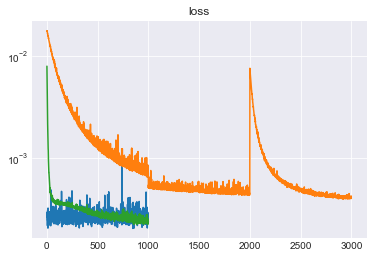

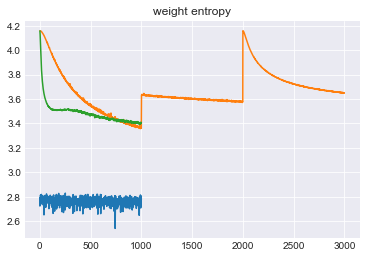

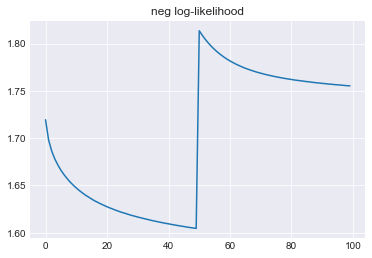

In [103]:
plt.plot(me_history.history['loss'])
plt.plot(hme_history.history['loss'])
plt.plot(hme_final_history.history['loss'])
plt.title('loss')
plt.yscale('log')
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

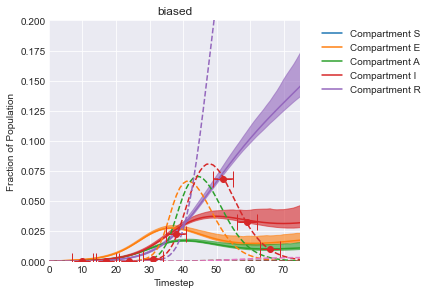

In [104]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
plt.ylim(0,0.2)
plt.xlim(0,75)
plt.title('biased')
plt.show()


## Direct Regression of Model

In [97]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 0.01
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, Mobility_martix_norm, T, infect, 201, agreement)

In [98]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()

150/150 [==============================] - 29s 191ms/step - loss: 0.0030 - output_2_loss: 0.00300s - loss: 0.0030 - output_2_loss: 0


## Visualizing results

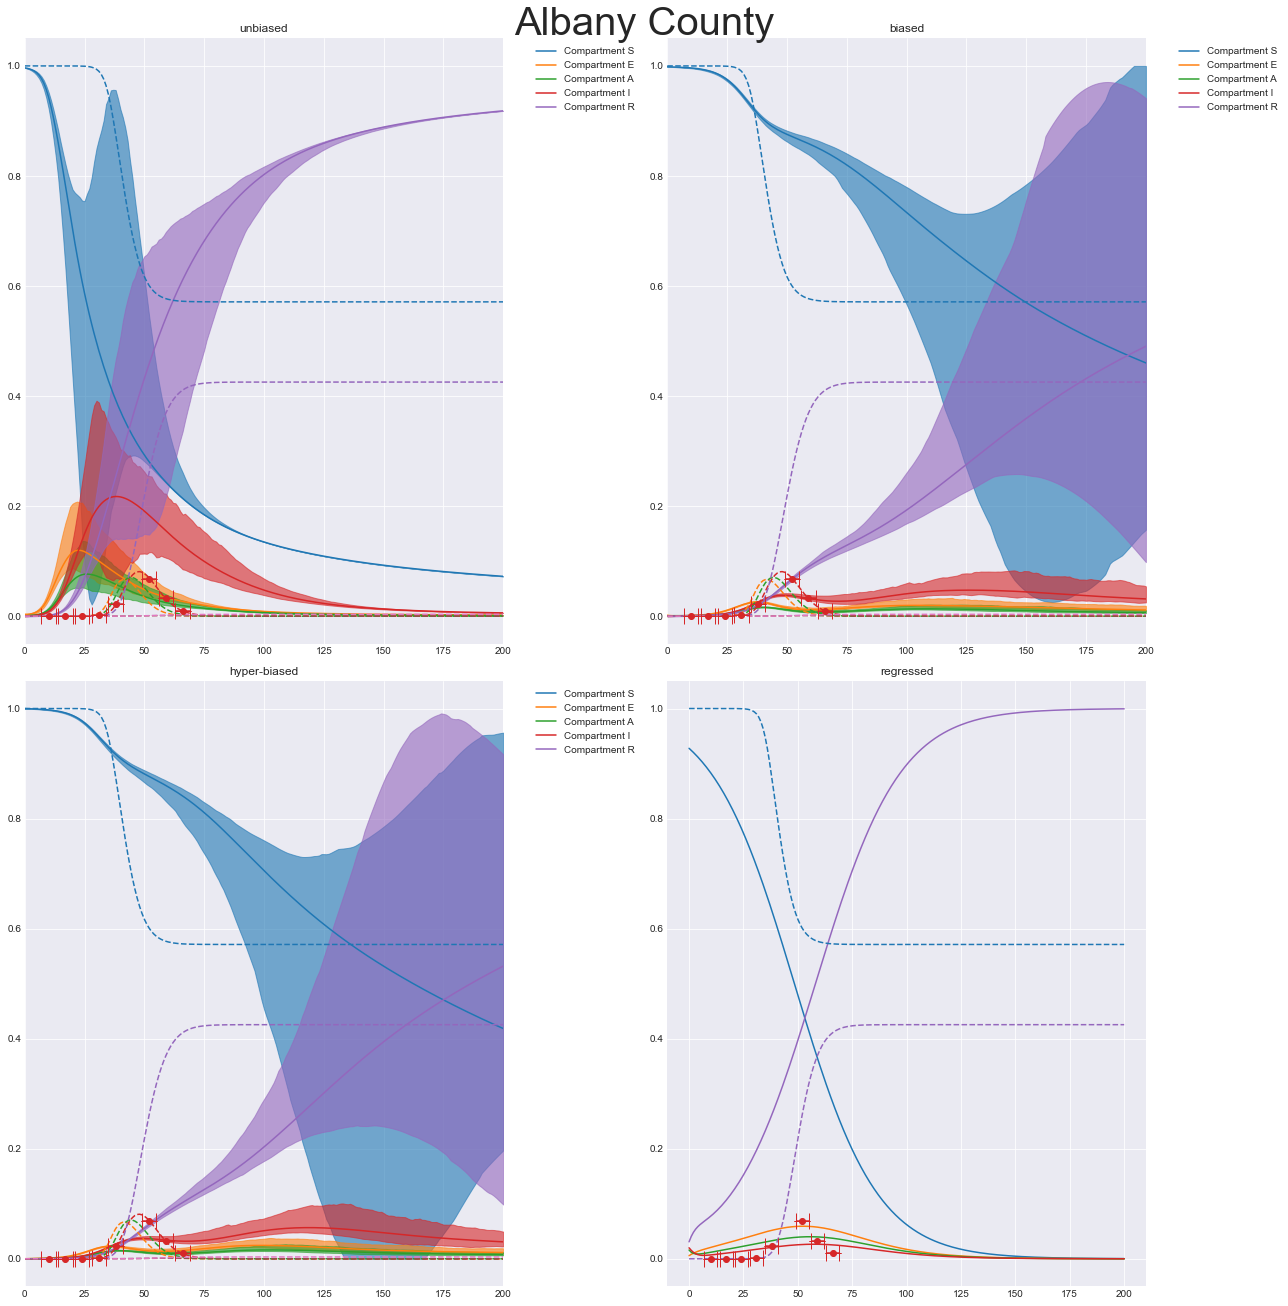

In [99]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

In [ ]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

In [ ]:
patch_number = 25
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
